In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/drive')
csv_path = "/content/drive/My Drive/Crystal_structure.csv"
data = pd.read_csv(csv_path)

data = data.drop(["In literature","Compound"], axis=1)
valency_a_one_hot = pd.get_dummies(data['v(A)'], prefix="v(A)=", prefix_sep="")
valency_b_one_hot = pd.get_dummies(data['v(B)'], prefix="v(B)=", prefix_sep="")
data = pd.concat([data, valency_a_one_hot, valency_b_one_hot], axis=1)
data = data.drop(["v(A)","v(B)","τ"], axis=1)
a_one_hot = pd.get_dummies(data['A'], prefix="A=", prefix_sep="")
b_one_hot = pd.get_dummies(data['B'], prefix="B=", prefix_sep="")
data = pd.concat([data, a_one_hot, b_one_hot], axis=1)
data = data.drop(["A","B"], axis=1)
data = data.drop(data[data["Lowest distortion"] == "-"].index)
data["Lowest distortion"] = data["Lowest distortion"].astype('category')
data["Lowest distortion"] = data["Lowest distortion"].cat.codes
features = data.drop(labels=["Lowest distortion"], axis=1)
target = data["Lowest distortion"]

SEED =   0
tf.random.set_seed(SEED)
np.random.seed(SEED)

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

INPUT_SHAPE = [len(X_train.columns)]
BATCH_SIZE =   32
model_1 = tf.keras.Sequential([
              tf.keras.layers.Dense(200, activation='relu', name="1st_layer", input_shape=(INPUT_SHAPE)),
              tf.keras.layers.Dropout(.2, name="1st_drop"),
              tf.keras.layers.Dense(200, activation='relu', name="2nd_layer"),
              tf.keras.layers.Dropout(.2, name="2nd_drop"),
              tf.keras.layers.Dense(200, activation='relu', name="3rd_layer"),
              tf.keras.layers.Dropout(.2, name="3rd_drop"),
              tf.keras.layers.Dense(100, activation='relu', name="4th_layer"),
              tf.keras.layers.Dropout(.2, name="4th_drop"),
              tf.keras.layers.Dense(50, activation='relu', name="5th_layer"),
              tf.keras.layers.Dropout(.2, name="5th_drop"),
              tf.keras.layers.Dense(4, activation='softmax', name="output_layer")
], name="model_1")

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

plot_model(model_1, show_shapes=True)

history_1 = model_1.fit(X_train, y_train,
                      epochs=25,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      verbose=False)

validation_loss, validation_acc = model_1.evaluate(X_val, y_val, verbose=False)
print(f'Validation loss: {validation_loss}, Validation accuracy: {validation_acc}')

test_loss, test_acc = model_1.evaluate(X_test, y_test, verbose=False)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation loss: 1.0677127838134766, Validation accuracy: 0.762326180934906
Test loss: 0.8562152981758118, Test accuracy: 0.8042929172515869


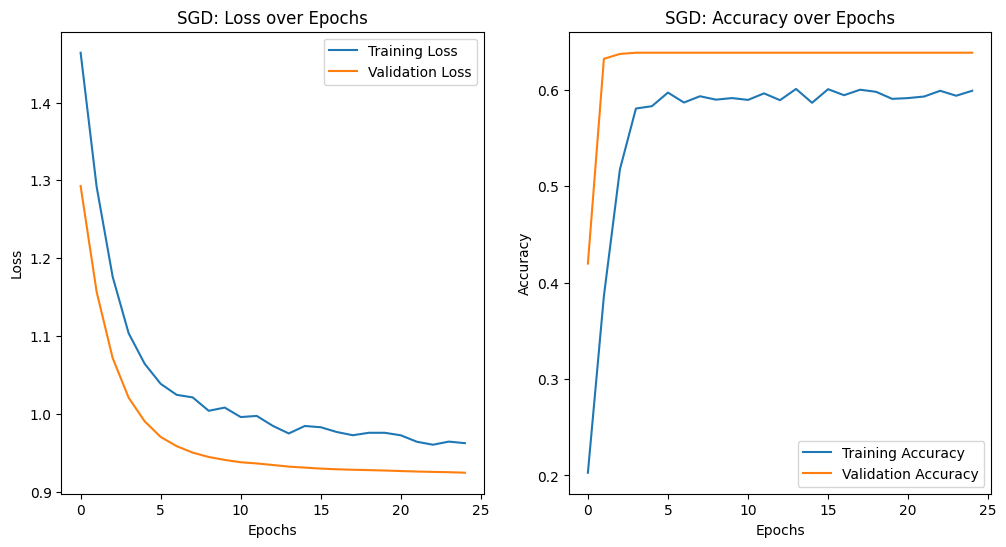

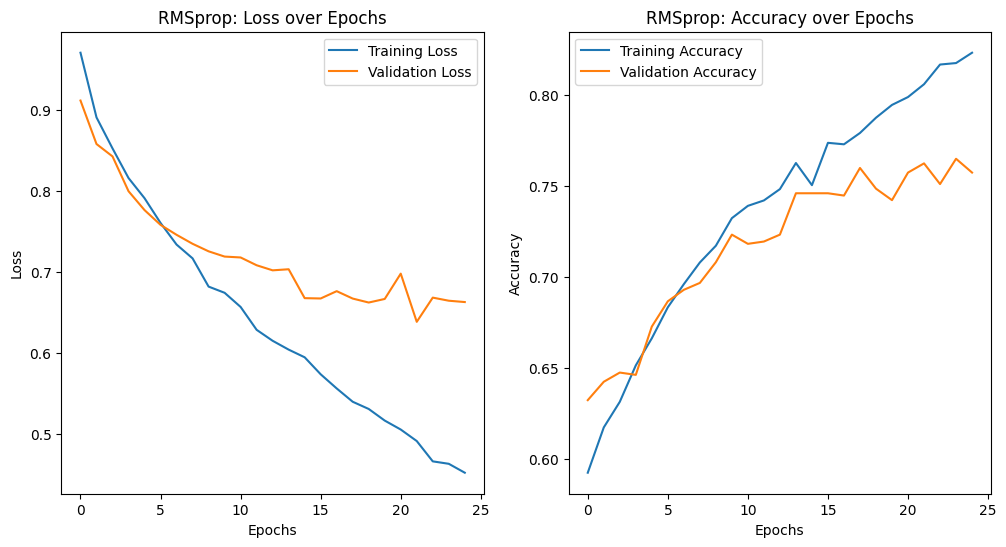

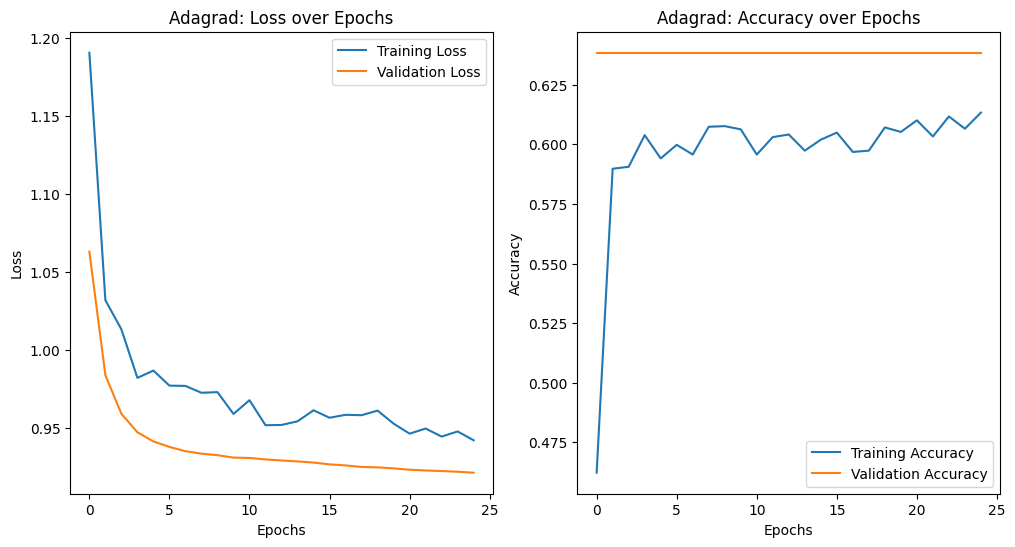

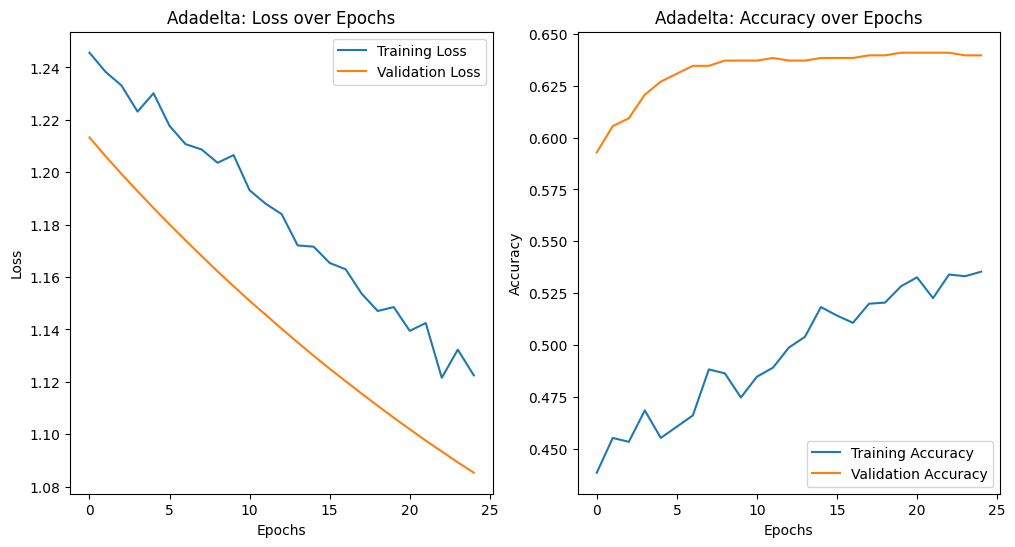

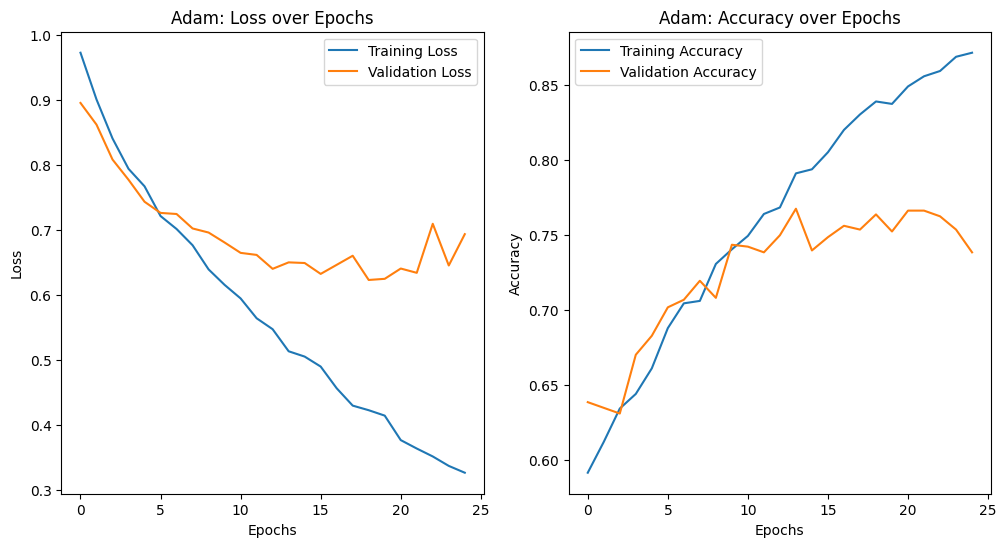

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
histories = {}

for optimizer in optimizers:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='relu', name="1st_layer", input_shape=(INPUT_SHAPE)),
        tf.keras.layers.Dropout(.4, name="1st_drop"),
        tf.keras.layers.Dense(200, activation='relu', name="2nd_layer"),
        tf.keras.layers.Dropout(.4, name="2nd_drop"),
        tf.keras.layers.Dense(100, activation='relu', name="3rd_layer"),
        tf.keras.layers.Dropout(.4, name="3rd_drop"),
        tf.keras.layers.Dense(4, activation='softmax', name="output_layer")
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.__dict__[optimizer](learning_rate=0.0005),
                  metrics=["accuracy"])

    histories[optimizer] = model.fit(X_train, y_train,
                                      epochs=25,
                                      batch_size=32,
                                      validation_data=(X_val, y_val),
                                      verbose=False)

def plot_results(histories):
    for optimizer, history in histories.items():
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{optimizer}: Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{optimizer}: Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

plot_results(histories)


**Conclusions:**

Stochastic Gradient Descent (SGD): The SGD Optimizer has an accuracy that takes a few iterations to converge due to its iterative nature however in the graph, there may be overfitting on the data as there is a sudden rise in the accuracy. The loss decreases steadily over the learning process.

RMSProp: There may be slight overfitting here as in both the loss and accuracy graphs, the validation data deviates from the nature of the training dataset. The loss and accuracy of the training data decrease linearly however, that of validation data decreases in a hyperbolic steady manner and converges eventually. Similar nature is shown by the accuracy graph converging eventually.
Achieves higher accuracy and lower loss than SGD but converges faster.

AdaDelta: Has accuracy comparable to SGD. It also has a smoother loss and accuracy curve because it has a self-adapting learning rate and hence, it isn't influenced by the initial learning rate much. Has a comparatively higher loss.

Adam: Achieves the highest accuracy for training dataset although performs poorly on the validation dataset. Also converges fast similar to RMSProp. Achieves the lowest loss for the training dataset.

Overall, Adam seems to be the best optimizer despite it performing poorly on the validation dataset, it still has relatively the highest accuracy and lowest loss.


